<a href="https://colab.research.google.com/github/gmauricio-toledo/NLP-LCC/blob/main/Notebooks/13-RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>RAG</h1>

<h3>Retrieval-augmented generation</h3>

RAG (*generación aumentada por recuperación*, por sus siglas en inglés) es una técnica que complementa la generación de texto con información de fuentes de datos. Combina un modelo de recuperación, que está diseñado para buscar en bases de conocimiento, con un modelo LLM, el cual que toma esa información y genera una respuesta en lenguaje natural.

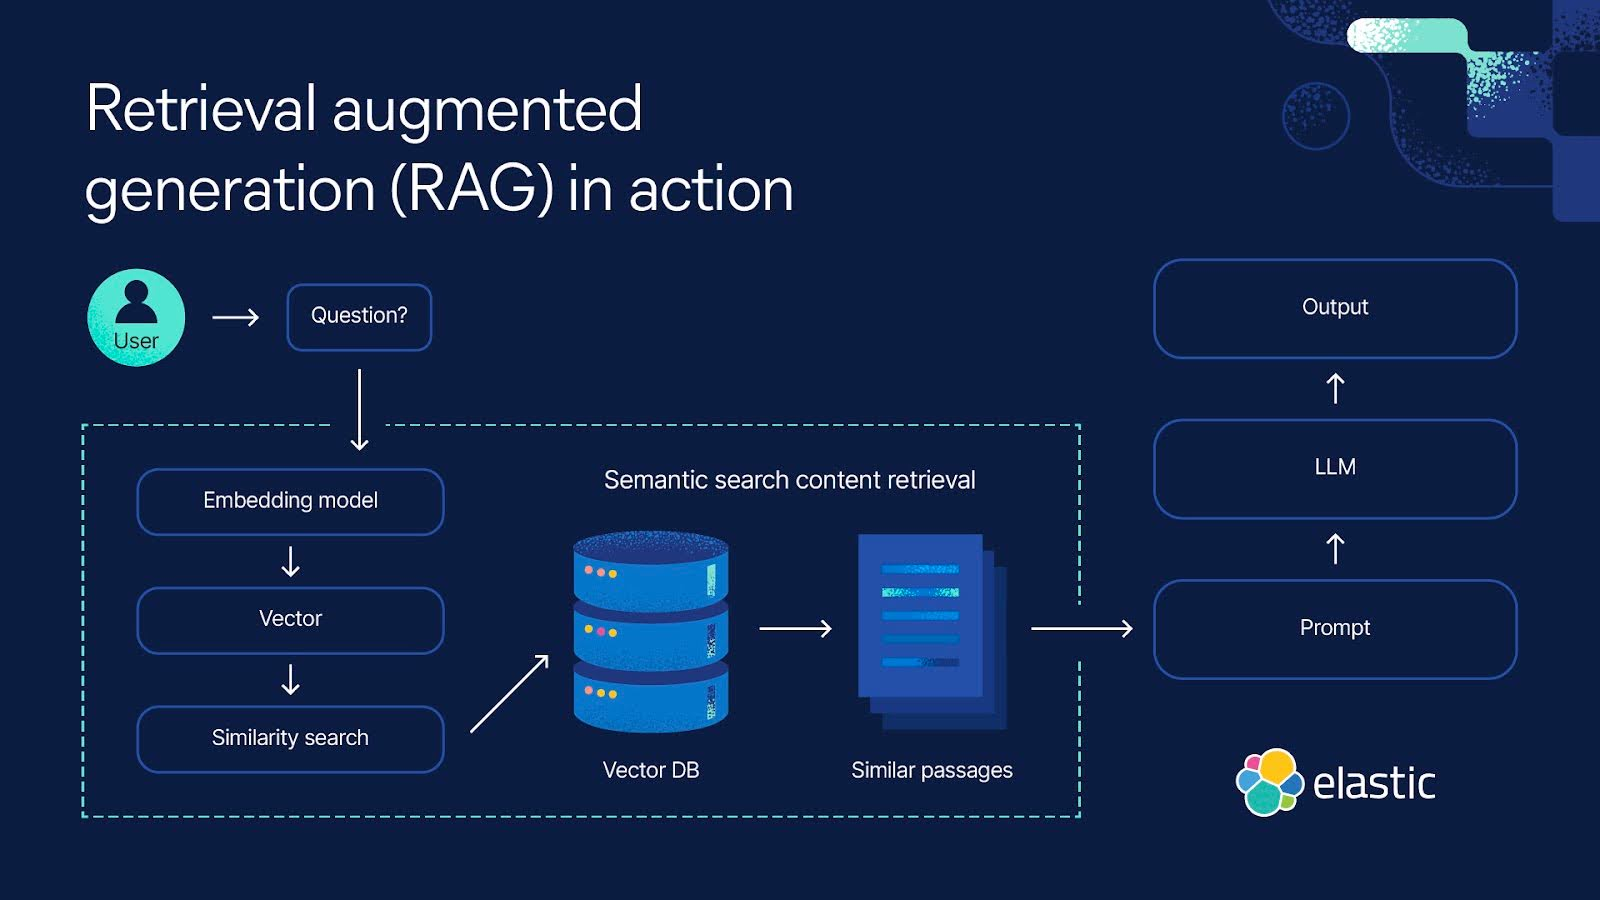

En esta notebook construiremos un modelo sencillo RAG para hacer consultas sobre información de los posgrados en la Universidad de Sonora. Usaremos el framework LangChain.

Comencemos haciendo algunas consultas con algunos LLMs. Preguntemos *¿cuánto dura la maestría en ciencia de datos de la universidad de sonora?*:

* ChatGPT.
* Algún modelo en Huggingface, [ejemplo](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct).
* Un modelo local.

¿Cuál es la diferencia entre ellos? ¿en qué radica el poder dar la respuesta correcta y relevante?

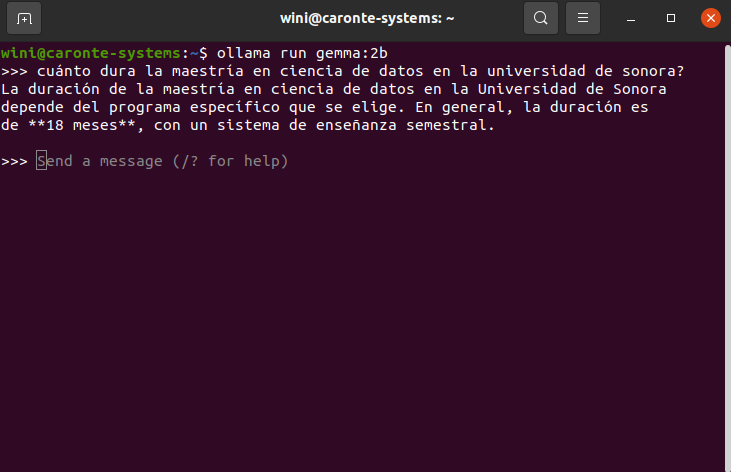

La respuesta es **RAG**. Veamos como funciona:

Instalamos los módulos necesarios

In [1]:
!pip install pypdf                  # Leer archivos PDF
!pip install -U langchain-community # Third-party integrations for LangChain
!pip install langchain              # Framework for developing applications powered by LLMs
!pip install chromadb               # Vector storage database
# !pip install boto3                  # Modulo para autentificarse en AWS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 117.0 MB/s eta 0:

Bajar algunos documentos PDF

In [1]:
!gdown 1sI80RrVCqGEGWkt2_K0N_q_c4mGquF7Q
!gdown 1eIoAGI4_YleCyynwzkLB-0DslwVYxiv0

Downloading...
From: https://drive.google.com/uc?id=1sI80RrVCqGEGWkt2_K0N_q_c4mGquF7Q
To: /content/MCD Lineamientos-internos.pdf
100% 106k/106k [00:00<00:00, 4.14MB/s]
Downloading...
From: https://drive.google.com/uc?id=1eIoAGI4_YleCyynwzkLB-0DslwVYxiv0
To: /content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf
100% 150k/150k [00:00<00:00, 3.77MB/s]


## Leemos los documentos PDF

Leemos todos los documentos de la carpeta `path` en un arreglo de `Document`, cada uno de ellos contiene información sobre la ruta del archivo y el contenido de cada página.

`PyPDFDirectoryLoader` es una utilidad proporcionada por la biblioteca LangChain que se usa para cargar documentos PDF desde un directorio específico .

In [2]:
from langchain.document_loaders.pdf import PyPDFDirectoryLoader

def load_documents(path):
    document_loader = PyPDFDirectoryLoader(path)
    return document_loader.load()

Especificamos la carpeta donde están los documentos:

In [3]:
path = '/content'

documents = load_documents(path)
documents[1]

Document(metadata={'producer': 'cairo 1.18.0 (https://cairographics.org)', 'creator': 'Mozilla Firefox 132.0', 'creationdate': '2024-11-25T13:56:56-07:00', 'source': '/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf', 'total_pages': 22, 'page': 1, 'page_label': '2'}, page_content='relevancia social, en función de los requerimientos socioeconómicos, culturales e históricos de la nación.\nDe ahí la necesidad de impulsar y reglamentar los estudios de posgrado que ofrece la Universidad de\nSonora.\nLa Ley Número 4 Orgánica que rige esta institución ha consolidado una estructura académica cuyo\nmodelo organizativo propicia la vinculación de la docencia y la investigación. De ahí que los estudios de\nposgrado, tanto por su incidencia en la formación de investigadores y en el desarrollo y apertura de líneas\nde investigación, como por su participación directa en la formación de cuadros profesionales de alto nivel,\nocupen un lugar destacado en la ascendente dinámica de nu

## Dividimos los documentos PDF en trozos

Usamos el [RecursiveCharacterTextSplitter](https://python.langchain.com/api_reference/text_splitters/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html#langchain_text_splitters.character.RecursiveCharacterTextSplitter) de LangChain

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema.document import Document

def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,           # Tamaño máximo de cada chunk en términos de número de caracteres
        chunk_overlap=80,         # Número de caracteres que se traslapan entre fragmentos consecutivos (para mantener contexto)
        length_function=len,      # Función utilizada para calcular la longitud del texto (en este caso, número de caracteres)
        is_separator_regex=False, # Indica si los separadores son expresiones regulares (False -> uso básico de saltos o divisores simples)
    )
    return text_splitter.split_documents(documents)

Separamos los documentos

In [5]:
chunks = split_documents(documents)

Visualicemos algunos ejemplos de *chunks*

In [6]:
print(chunks[0])
print(30*"-")
print(chunks[1])
print(30*"-")
print(chunks[2])

page_content='REGLAMENTO DE ESTUDIOS DE POSGRADO
EXPOSICIÓN DE MOTIVOS
ÁMBITO DE VALIDEZ
ÁMBITO DE COMPETENCIA Y ORIENTACIONES GENERALES
CAPÍTULO I
Disposiciones Generales
CAPÍTULO II
De la organización
CAPÍTULO III
Del Personal Académico
CAPÍTULO IV
De los Planes y Programas de Estudio
CAPÍTULO V
De los Programas de Posgrado Interinstitucionales
CAPÍTULO VI
De los Estudiantes
CAPÍTULO VII
De los Derechos y Obligaciones de los Estudiantes
CAPÍTULO VIII
De las Inscripciones
CAPÍTULO IX
De las Reinscripciones
CAPÍTULO X
De las Evaluaciones
CAPÍTULO XI
De las Bajas
CAPÍTULO XII
De los Diplomas y Grados
CAPÍTULO XIII
De la Revalidación, Equivalencia y Conmutación
TRANSITORIOS
EXPOSICIÓN DE MOTIVOS
Las transformaciones sociales, económicas y políticas en el nivel nacional e internacional que se viven' metadata={'producer': 'cairo 1.18.0 (https://cairographics.org)', 'creator': 'Mozilla Firefox 132.0', 'creationdate': '2024-11-25T13:56:56-07:00', 'source': '/content/Reglamento de Estudios de

## Asignamos un embedding a cada trozo y almacenamos los embeddings en una base de datos

* [Bedrock embeddings](https://python.langchain.com/api_reference/aws/embeddings/langchain_aws.embeddings.bedrock.BedrockEmbeddings.html). Titan Embeddings de [AWS](https://aws.amazon.com/bedrock/?nc1=h_ls) (más [detalles](https://www.philschmid.de/amazon-titan-embeddings) de los embeddings).
* [HuggingFace embeddings](https://api.python.langchain.com/en/latest/huggingface/embeddings/langchain_huggingface.embeddings.huggingface.HuggingFaceEmbeddings.html). Embeddings de [Sentence BERT](https://huggingface.co/sentence-transformers/all-mpnet-base-v2).
* [HuggingFaceBgeEmbeddings](https://python.langchain.com/api_reference/community/embeddings/langchain_community.embeddings.huggingface.HuggingFaceBgeEmbeddings.html) es una clase de la biblioteca LangChain diseñada para interactuar con modelos de embeddings de la familia BGE (Bidirectional General Encoder) alojados en Hugging Face, los cuales generan representaciones vectoriales del texto que permiten medir similitudes semánticas entre frases o documentos, los podemos usar en tareas como búsqueda semántica, clustering de textos o RAG.

In [8]:
!pip install -qU langchain-huggingface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.6 MB/s eta 0:00:00


In [10]:
from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain_community.embeddings.bedrock import BedrockEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.embeddings import HuggingFaceBgeEmbeddings

def get_embedding_function():
    # embeddings = BedrockEmbeddings(
    #     credentials_profile_name="default", region_name="us-east-1"
    # )
    # embeddings = OllamaEmbeddings(model="nomic-embed-text")
    # embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
    embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en-v1.5")
    return embeddings

Ahora definamos la base de datos de vectores. **ChromaDB** es una buena opción para trabajar con bases de datos vectoriales en entornos locales, también podrías considerar otras alternativas:

- **[ChromaDB](https://www.trychroma.com/)**: Ideal para proyectos que requieren simplicidad y facilidad de uso, especialmente en ambientes no escalables.
- **[FAISS (Facebook AI Similarity Search)](https://github.com/facebookresearch/faiss)**: Una alternativa muy eficiente si buscas velocidad en búsquedas vectoriales locales.

Ambas herramientas son útiles dentro del ecosistema RAG, pero la elección dependerá del contexto (si necesitas mayor rapidez o escalamiento).

In [11]:
from langchain.vectorstores.chroma import Chroma

CHROMA_PATH = "chroma"

def add_to_chroma(chunks: list[Document]):
    # Leer la DB existente
    db = Chroma(
        persist_directory=CHROMA_PATH, embedding_function=get_embedding_function()
    )

    # Calcular los IDs de chunks.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Agregar o actualizar documentos.
    existing_items = db.get(include=[])
    existing_ids = set(existing_items["ids"])
    print(f"Número de documentos existentes en la DB: {len(existing_ids)}")

    # Sólo agregar los documentos que no estén en la DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)

    if len(new_chunks):
        print(f"Agregando {len(new_chunks)} nuevos documentos")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
        db.persist()
    else:
        print("No hay nuevos documentos para agregar")

def calculate_chunk_ids(chunks):

    # Función para crear los IDs de tipo "content/file.pdf:6:2"
    # Page Source : Page Number : Chunk Index

    last_page_id = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")
        page = chunk.metadata.get("page")
        current_page_id = f"{source}:{page}"

        # Si el page ID es el mismo que el anterior, incrementar el índice
        if current_page_id == last_page_id:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        # Calcular el chunk ID.
        chunk_id = f"{current_page_id}:{current_chunk_index}"
        last_page_id = current_page_id

        # Add it to the page meta-data.
        chunk.metadata["id"] = chunk_id

    return chunks

Contruimos o actualizamos la DB

In [12]:
add_to_chroma(chunks)

<ipython-input-10-99998157676b>:12: LangChainDeprecationWarning: The class `HuggingFaceBgeEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceBgeEmbeddings(model_name="BAAI/bge-small-en-v1.5")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

<ipython-input-11-134ddf415ccc>:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(


Número de documentos existentes en la DB: 0
Agregando 99 nuevos documentos


<ipython-input-11-134ddf415ccc>:29: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  db.persist()


## Interrogamos al LLM sobre cualquier tópico

Usaremos un LLM de transformers de HuggingFace.

Definimos el modelo:

In [13]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen2.5-1.5B-Instruct"
# model_name = "Qwen/Qwen3-0.6B"
# model_name = "Qwen/Qwen-7B-Chat"
# model_name = "mosaicml/mpt-7b""
# model_name = "tiiuae/falcon-7b-instruct"
# model_name = "microsoft/Phi-3.5-mini-instruct"
# model_name = "mistralai/Mistral-7B-Instruct-v0.3"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

La función para interrogar al LLM con RAG

In [19]:
import argparse
from langchain.vectorstores.chroma import Chroma
from langchain.prompts import ChatPromptTemplate

PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

def query_rag(query_text: str):
    # Preparar la DB
    embedding_function = get_embedding_function()
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

    # Buscar en la DB
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)
    # print(prompt)

    messages = [
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
    )

    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
        **model_inputs,
        max_new_tokens=256
    )
    generated_ids = [
        output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
    ]
    response_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

    sources = [doc.metadata.get("id", None) for doc, _score in results]
    formatted_response = f"------ Response ------\n{response_text}\n\n------  Sources ------ \n"
    print(formatted_response)
    # Listar las fuentes
    for source in sources:
        print(source)
    return response_text




Finalmente podemos hacer las consultas al LLM

In [20]:
respuesta = query_rag("CUAL ES EL MECANISMO PARA GRADUARSE DE UNA MAESTRIA?")

------ Response ------
Según el contexto proporcionado, para graduarse de una Maestría en la Universidad de Sonora:

1. Un estudiante debe completar todos los créditos programáticos establecidos para el programa de maestría.
2. Además, debe acreditarse la comprensión de un idioma diferente al español (si corresponde).
3. El estudiante también debe aprobar un examen de grado tanto en la fase escrita como en la fase oral.
4. Si es necesario, debe aprobar un examen general de conocimientos específico para el doctorado.
5. Finalmente, debe cumplir con todas las disposiciones y requisitos requeridos por la Dirección de Servicios Escolares para expedir el título.

El proceso completo se realiza dentro de los plazos máximos establecidos en el artículo 11 del mismo documento, que varían según la especialidad (un año y seis meses) o la maestría (dos años y seis meses).

Es importante notar que esta información es específica para la Universidad de Sonora, y puede variar dependiendo del programa 

In [21]:
respuesta = query_rag("cuánto dura la maestría en ciencia de datos?")

------ Response ------
La duración de la maestría en Ciencias de Datos, según el texto, es de dos años y seis meses.

------  Sources ------ 

/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:4:2
/content/MCD Lineamientos-internos.pdf:3:0
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:5:1
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:5:0
/content/MCD Lineamientos-internos.pdf:0:0


In [22]:
respuesta = query_rag("cuánto dura una maestría en la unison?")

------ Response ------
Según el texto proporcionado, la duración de una Maestría en la Universidad Unison es de **2 años y seis meses**.

------  Sources ------ 

/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:21:0
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:20:1
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:16:3
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:5:1
/content/Reglamento de Estudios de Posgrado Universidad de Sonora.pdf:6:4


La calidad de las respuestas depende de:

* Documentos de consulta
* División de los documentos de consulta
* Embeddings
* Prompt
* LLM

¿Cómo podemos evaluar la calidad de este sistema?

## Further Reading and Techniques

* Curso Gratis de Nvidia: https://learn.nvidia.com/courses/course-detail?course_id=course-v1:DLI+S-FX-15+V1
* Advanced RAG Techniques: Collection of RAG tutorials: https://github.com/NirDiamant/RAG_Techniques